In [ ]:
!pip install transformers datasets evaluate peft accelerate bitsandbytes torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 15.8 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=7983d0fd5cf409999f2c47ea1c355bdc50ce619154c5aeb683564e6c996f6579
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [ ]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.2 MB/s eta 0:00:00


In [ ]:
# STEP 1: Load and clean MedDialog dataset
import json
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

def load_and_filter_dataset(path):
    with open(path, "r") as f:
        data = json.load(f)

    cleaned_data = []
    for entry in data:
        utterances = entry.get("utterances", [])
        if len(utterances) < 2:
            continue
        patient = utterances[0].replace("patient:", "").strip()
        doctor = utterances[1].replace("doctor:", "").strip()

        if 10 < len(doctor.split()) < 100:  # filter bad/short/long responses
            input_text = f"You are a helpful telehealth doctor. Provide a short, clear response.\nPatient: {patient}\nDoctor:"
            cleaned_data.append({"input": input_text, "output": doctor})

    return pd.DataFrame(cleaned_data)

# Load datasets
train_df = load_and_filter_dataset("english-train.json")
val_df   = load_and_filter_dataset("english-dev.json")
test_df  = load_and_filter_dataset("english-test.json")

# Split 20% of train data for validation (benchmarking)
train_df, benchmark_df = train_test_split(train_df, test_size=0.2, random_state=42)

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "benchmark": Dataset.from_pandas(benchmark_df),  # Benchmark dataset (20%)
    "test": Dataset.from_pandas(test_df)
})

In [ ]:
# After loading all datasets
print("Dataset Sizes")
print(f"Total samples before split (train.json): {len(load_and_filter_dataset('english-train.json'))}")
print(f"Validation (dev.json): {len(val_df)}")
print(f"Test (test.json): {len(test_df)}")

# Sizes after your 80/20 split
print("\nAfter Split (train - train + benchmark)")
print(f"Train size: {len(train_df)}")
print(f"Benchmark (20% of train): {len(benchmark_df)}")
print(f"Validation (dev): {len(val_df)}")
print(f"Test size: {len(test_df)}")

# Final
print("\nFinal")
print(f"Total samples before split: {len(train_df) + len(benchmark_df)}")
print(f"Train size: {len(train_df)}")
print(f"Eval size: {len(benchmark_df)}")
print(f"Test size: {len(test_df)}")

Dataset Sizes
Total samples before split (train.json): 2001
Validation (dev.json): 142
Test (test.json): 355

After Split (train - train + benchmark)
Train size: 1600
Benchmark (20% of train): 401
Validation (dev): 142
Test size: 355

Final
Total samples before split: 2001
Train size: 1600
Eval size: 401
Test size: 355


In [ ]:
# STEP 2: Tokenize data for flan-t5-base
from transformers import T5Tokenizer

model_name = "google/flan-t5-base"  # Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained(model_name)   # Load the pretrained FLAN-T5-Base model

def preprocess(example):
    inputs = tokenizer(example["input"], padding="max_length", truncation=True, max_length=512)
    targets = tokenizer(example["output"], padding="max_length", truncation=True, max_length=128)
    inputs["labels"] = [t if t != tokenizer.pad_token_id else -100 for t in targets["input_ids"]]
    return inputs

tokenized_dataset = dataset.map(preprocess, batched=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

In [ ]:
# STEP 3: Setup PEFT LoRA config
from transformers import T5ForConditionalGeneration
from peft import get_peft_model, LoraConfig, TaskType

model = T5ForConditionalGeneration.from_pretrained(model_name)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q", "v", "k", "o", "wi", "wo"],
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)

model = get_peft_model(model, lora_config)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# STEP 4: Setup Trainer
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./flan-t5-base-telehealth-lora",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=30,
    weight_decay=0.01,
    logging_steps=20,
    report_to="none",
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["benchmark"],  # Evaluation on benchmark dataset
    tokenizer=tokenizer
)

trainer.train()
model.save_pretrained("./flan-t5-base-telehealth-lora")

/tmp/ipython-input-4245134283.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.232500,0.922221
2,0.888600,0.833157
3,0.786000,0.789624
4,0.898400,0.761712
5,0.756300,0.741800
6,0.710400,0.728316
7,0.907600,0.710487
8,0.693800,0.699710
9,0.795400,0.689593
10,0.641500,0.681998


In [ ]:
# STEP 5: Evaluate (ROUGE + BERTScore)

import torch
from evaluate import load
from datasets import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rouge = load("rouge")
bertscore = load("bertscore")

def evaluate_model(model, eval_df):
    preds, refs = [], []

    # Convert the Dataset to a pandas DataFrame
    eval_df = eval_df.to_pandas()

    for i, row in eval_df.iterrows():
        patient_text = row["input"].split("Patient:")[1].split("\n")[0].strip()
        prompt = f"You are a helpful telehealth doctor. Provide a short, clear response.\nPatient: {patient_text}\nDoctor:"
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(device)
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            num_beams=4,
            early_stopping=True,
            repetition_penalty=1.2,
            no_repeat_ngram_size=3
        )
        preds.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
        refs.append(row["output"])

    # Evaluate ROUGE
    rouge_result = rouge.compute(predictions=preds, references=refs)

    # Evaluate BERTScore
    bert_result = bertscore.compute(predictions=preds, references=refs, lang="en")

    return rouge_result, sum(bert_result["f1"]) / len(bert_result["f1"])

# Evaluate pretrained model
print("Evaluating Pretrained Model on Benchmark Dataset...")
pre_model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
pre_rouge, pre_bert = evaluate_model(pre_model, dataset["benchmark"])

# Evaluate LoRA fine-tuned model
print("Evaluating LoRA Fine-Tuned Model on Benchmark Dataset...")
lora_model = T5ForConditionalGeneration.from_pretrained("./flan-t5-base-telehealth-lora").to(device)
lora_rouge, lora_bert = evaluate_model(lora_model, dataset["benchmark"])

# Performance comparison (Before vs After Fine-Tuning)
import pandas as pd

comparison_df = pd.DataFrame({
    "Metric": ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore-F1"],
    "Pretrained": [
        pre_rouge["rouge1"],
        pre_rouge["rouge2"],
        pre_rouge["rougeL"],
        pre_bert,
    ],
    "LoRA Fine-Tuned": [
        lora_rouge["rouge1"],
        lora_rouge["rouge2"],
        lora_rouge["rougeL"],
        lora_bert,
    ]
})

print(comparison_df)
comparison_df.to_csv("benchmark_model_comparison.csv", index=False)

Evaluating Pretrained Model on Benchmark Dataset...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating LoRA Fine-Tuned Model on Benchmark Dataset...
         Metric  Pretrained  LoRA Fine-Tuned
0       ROUGE-1    0.047819         0.414246
1       ROUGE-2    0.006027         0.218925
2       ROUGE-L    0.041879         0.366255
3  BERTScore-F1    0.837975         0.902521


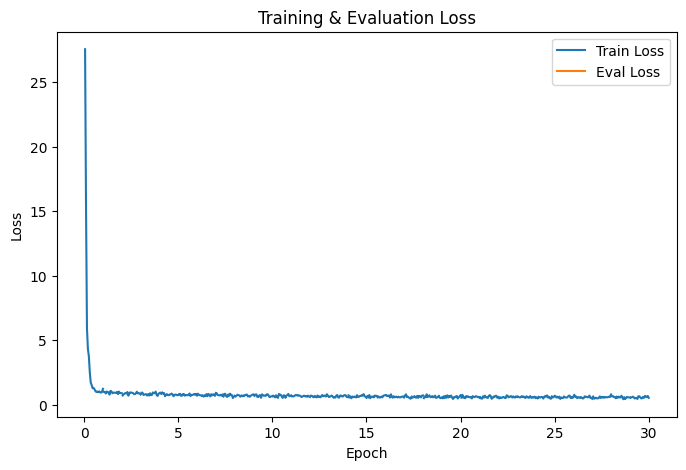

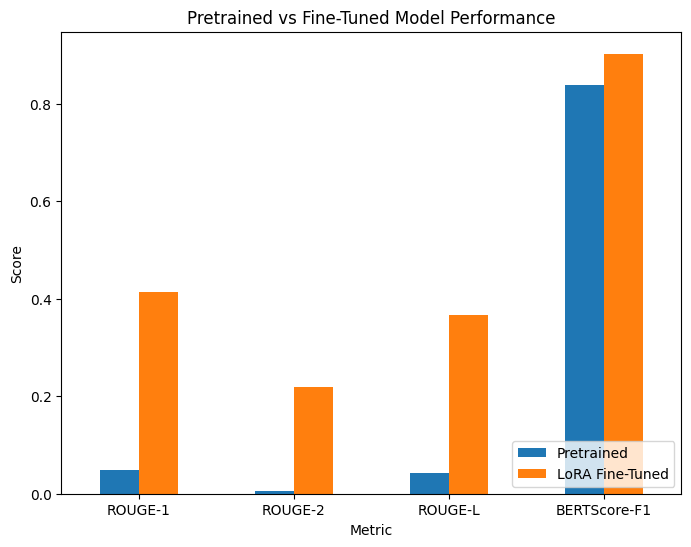

In [ ]:
# Visualization
import matplotlib.pyplot as plt

def plot_training_logs(trainer):
    logs = pd.DataFrame(trainer.state.log_history)
    if "loss" in logs.columns:
        plt.figure(figsize=(8,5))
        plt.plot(logs["epoch"], logs["loss"], label="Train Loss")
        if "eval_loss" in logs.columns:
            plt.plot(logs["epoch"], logs["eval_loss"], label="Eval Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training & Evaluation Loss")
        plt.legend()
        plt.savefig("training_loss_curve.png")
        plt.show()

# Call after training
plot_training_logs(trainer)

# Metric Comparison Plot
def plot_metrics(comparison_df):
    comparison_df.set_index("Metric").plot(kind="bar", figsize=(8,6))
    plt.title("Pretrained vs Fine-Tuned Model Performance")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.legend(loc="lower right")
    plt.savefig("model_comparison_metrics.png")
    plt.show()

# Call after comparison_df is created
plot_metrics(comparison_df)

In [ ]:
# Prompt engineering
# Step 1: Define the prompt engineering template with enhanced responses
def build_prompt(input_text, prompt_type="general"):
    input_text = input_text.strip()

    if prompt_type == "general":
        return (
            f"You are a helpful telehealth doctor. Provide a clear, actionable response with medical context and next steps.\n"
            f"Patient: {input_text}\nDoctor:"
        )

    elif prompt_type == "diagnosis":
        return (
            f"You are a licensed telehealth physician. Assess the symptoms and explain 1-2 possible causes with suggested next steps.\n"
            f"Patient: {input_text}\nDoctor:"
        )

    elif prompt_type == "psychological":
        return (
            f"You are a compassionate telehealth doctor. Reassure the patient, then provide steps to manage their mental well-being.\n"
            f"Patient: {input_text}\nDoctor:"
        )

    elif prompt_type == "medication":
        return (
            f"You are a helpful telehealth doctor. If medication is needed, suggest general types (not specific brands). Include dosage instructions and when to consult with a healthcare provider.\n"
            f"Patient: {input_text}\nDoctor:"
        )

    else:
        raise ValueError("Unsupported prompt type.")

In [ ]:
# Step 2: Generate answers based on the prompt type
def generate_answer(input_text, model, tokenizer, prompt_type="general"):
    prompt = build_prompt(input_text, prompt_type)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(model.device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=128,   # 64
        num_beams=4,
        early_stopping=True,
        repetition_penalty=1.2,
        no_repeat_ngram_size=3
    )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    if response.lower().startswith("doctor:"):
        response = response[7:].strip()
    return response

In [ ]:
# Step 3: Evaluate the model with different prompt types
def evaluate_model(model, tokenizer, test_df, prompt_type="general"):
    from evaluate import load
    rouge = load("rouge")
    bertscore = load("bertscore")

    preds, refs = [], []
    for _, row in test_df.iterrows():
        patient_text = row["input"].split("Patient:")[1].split("\n")[0].strip()
        prompt = build_prompt(patient_text, prompt_type)
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(model.device)
        outputs = model.generate(
            **inputs,
            max_new_tokens=64,
            num_beams=4,
            early_stopping=True,
            repetition_penalty=1.2,
            no_repeat_ngram_size=3
        )
        preds.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
        refs.append(row["output"])

    rouge_result = rouge.compute(predictions=preds, references=refs)
    bert_result = bertscore.compute(predictions=preds, references=refs, lang="en")
    return rouge_result, sum(bert_result["f1"]) / len(bert_result["f1"])

In [ ]:
# Step 4: Perform evaluation with different prompt types

results = []

for prompt_type in ["general", "diagnosis", "psychological", "medication"]:
    rouge_result, bert_f1 = evaluate_model(model, tokenizer, test_df, prompt_type=prompt_type)
    results.append({
        "Prompt Type": prompt_type,
        "ROUGE-1": rouge_result["rouge1"],
        "ROUGE-2": rouge_result["rouge2"],
        "ROUGE-L": rouge_result["rougeL"],
        "BERTScore-F1": bert_f1
    })
    print(f"\nPrompt Type: {prompt_type}")
    print(f"ROUGE-1: {rouge_result['rouge1']:.4f}")
    print(f"ROUGE-2: {rouge_result['rouge2']:.4f}")
    print(f"ROUGE-L: {rouge_result['rougeL']:.4f}")
    print(f"BERTScore-F1: {bert_f1:.4f}")

# Convert results to DataFrame
df_results = pd.DataFrame(results)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Prompt Type: general
ROUGE-1: 0.3620
ROUGE-2: 0.1498
ROUGE-L: 0.3113
BERTScore-F1: 0.8934


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Prompt Type: diagnosis
ROUGE-1: 0.3590
ROUGE-2: 0.1456
ROUGE-L: 0.3078
BERTScore-F1: 0.8922


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Prompt Type: psychological
ROUGE-1: 0.3570
ROUGE-2: 0.1466
ROUGE-L: 0.3107
BERTScore-F1: 0.8930


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Prompt Type: medication
ROUGE-1: 0.3189
ROUGE-2: 0.1200
ROUGE-L: 0.2733
BERTScore-F1: 0.8861


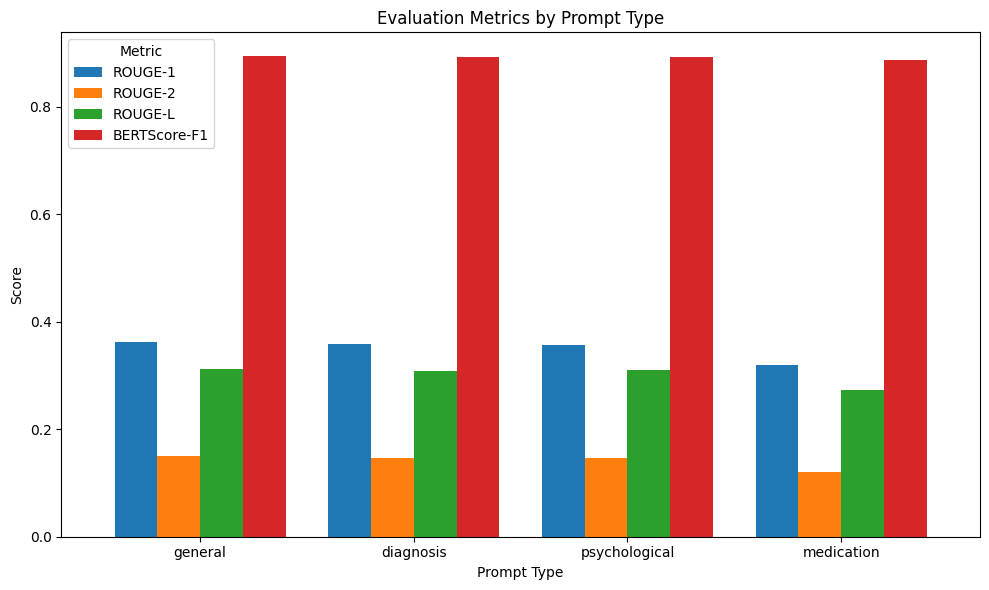

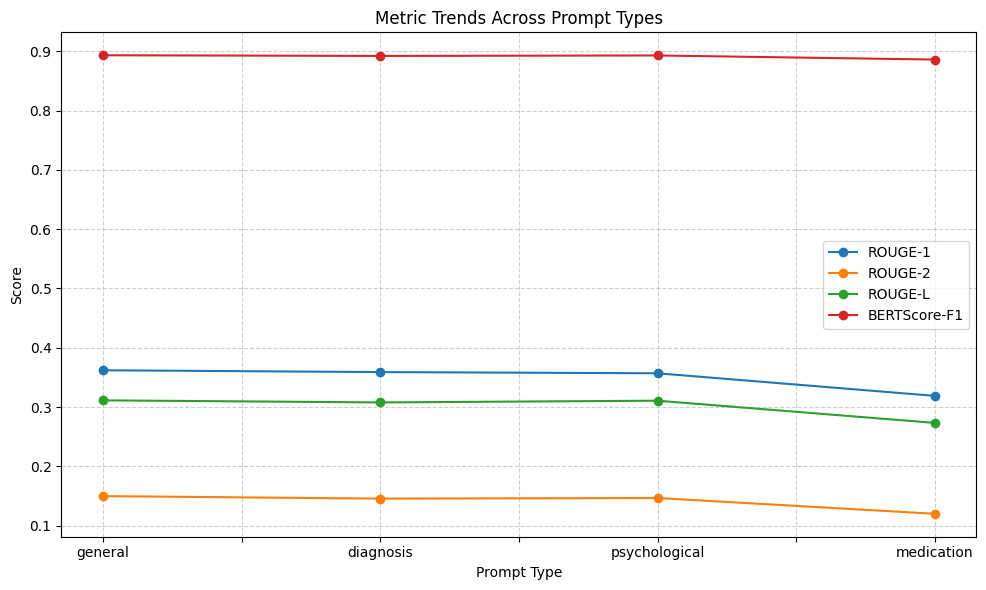

In [ ]:
# Visualization 1: Grouped Bar Plot (comparison across metrics)
df_results.set_index("Prompt Type")[["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore-F1"]].plot(
    kind="bar", figsize=(10,6), width=0.8
)
plt.title("Evaluation Metrics by Prompt Type")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.tight_layout()
plt.savefig("prompt_type_evaluation.png")
plt.show()

# Visualization 2: Line Plot (trend across prompt types)
df_results.set_index("Prompt Type")[["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore-F1"]].plot(
    kind="line", marker="o", figsize=(10,6)
)
plt.title("Metric Trends Across Prompt Types")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("prompt_type_trends.png")
plt.show()

In [ ]:
# Step 5: Interactive Chat with the model
def chat_with_model(model, tokenizer):
    print("\nTelehealth Assistant is ready.")
    print("Please choose a prompt mode:")
    print("1 - General")
    print("2 - Diagnosis")
    print("3 - Psychological")
    print("4 - Medication")

    mode_map = {
        "1": "general",
        "2": "diagnosis",
        "3": "psychological",
        "4": "medication"
    }

    mode = input("Enter mode number (1-4): ").strip()
    prompt_type = mode_map.get(mode, "general")  # default to general

    print(f"\nPrompt mode set to [{prompt_type.upper()}]. Type 'exit' to quit.\n")

    while True:
        user_input = input("Patient: ").strip()
        if user_input.lower() == "exit":
            print("Thank you. Stay healthy!")
            break
        doctor_reply = generate_answer(user_input, model, tokenizer, prompt_type=prompt_type)
        print("Doctor:", doctor_reply, "\n")

# Start the chat system
chat_with_model(model, tokenizer)


Telehealth Assistant is ready.
Please choose a prompt mode:
1 - General
2 - Diagnosis
3 - Psychological
4 - Medication
Enter mode number (1-4): 1

Prompt mode set to [GENERAL]. Type 'exit' to quit.

Patient: Hey Doc, I’ve been sneezing nonstop, do you think it’s just allergies?
Doctor: it may be allergies. Stay hydrated, use antihistamines if needed, and monitor symptoms. Seek care if symptoms persist or worsen. 

Patient: I’ve had a cough and low-grade fever for three days. Should I be worried?
Doctor: this may be a mild viral infection. Rest, hydrate, and monitor. Seek care if symptoms worsen or persist. 

Patient: I just twisted my ankle while jogging. It’s swollen but not bruised, should I get an X-ray?
Doctor: swollen ankle. Rest, ice, compression, and compression may help. Seek medical attention if swelling worsens, blisters, or is severe. 

Patient: Is it okay to exercise if I have a cold?
Doctor: if you are not able to exercise, rest, hydrate, and monitor symptoms. If symptoms

In [1]:
!jupyter nbconvert --to pdf Model_FAQ_Telehealth_Flan_T5_Base_OhWenChi.ipynb

[NbConvertApp] Converting notebook Model_FAQ_Telehealth_Flan_T5_Base_OhWenChi.ipynb to pdf
[NbConvertApp] Support files will be in Model_FAQ_Telehealth_Flan_T5_Base_OhWenChi_files\
[NbConvertApp] Making directory .\Model_FAQ_Telehealth_Flan_T5_Base_OhWenChi_files
[NbConvertApp] Writing 94047 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 185135 bytes to Model_FAQ_Telehealth_Flan_T5_Base_OhWenChi.pdf
